<a href="https://colab.research.google.com/github/nonoumasy/Airbnb-Lisbon-Analysis/blob/master/Lisbon_Airbnb_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Airbnb in Lisbon

For city X, I want to know:
* avg price
* Most expensive month 
* Least expensive month
* Busiest month(occ rate)
* Less busiest month
* Avg rating per neighborhood
* Most popular neighoborhood
* Most expensive neighborhood
* Least expensive neighborhood
* Neighborhood summary
* Best listing at neighborhood X
* Quietest neighborhood
* Safest neighborhood
* Most touristy neighborhood
* Neighborhood word cloud
* Listing keywords
* find avg Price according vs room's type
* find avg Price according vs neighborhood and how many booked there
* plot reviews vs prices
* plot reviews vs overall satisfaction
* plot overall satisfaction vs price



# Import Packages

In [43]:
!pip install geopandas
!pip install geopy
!pip install folium
!pip install langdetect
!pip install overpy

     |████████████████████████████████| 51kB 4.7MB/s 
  Created wheel for overpy: filename=overpy-0.4-cp36-none-any.whl size=45774 sha256=ca488c53963920883b3dc85135d76341f42bf56057d4eb23bc71602dcef6a254
  Stored in directory: /root/.cache/pip/wheels/10/53/c2/e6b6f97e7bb419193bd3aafbe38628666f0f93a1cec9dc521d
Successfully built overpy


In [0]:
import pandas as pd
import geopandas as gpd
import datetime as dt
import overpy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import folium
from folium.plugins import HeatMap, FastMarkerCluster
from langdetect import detect_langs
from textblob import TextBlob
from wordcloud import WordCloud 
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

%matplotlib inline

# Data Source

In [0]:
#data from insideairbnb.com
reviews = '/Users/nonoumasy/Google Drive/Colab Notebooks/airbnb_lisbon/reviews.csv'
listings = '/Users/nonoumasy/Google Drive/Colab Notebooks/airbnb_lisbon/listings.csv'
cal = '/Users/nonoumasy/Google Drive/Colab Notebooks/airbnb_lisbon/calendar.csv'

listings_df = pd.read_csv(listings,)
reviews_df = pd.read_csv(reviews,)
cal_df = pd.read_csv(cal,)
df = pd.read_csv(listings)

#change date to datetime object
reviews_df.date = pd.to_datetime(reviews_df.date)
reviews_df.set_index('date', inplace=True,)
reviews_df.sort_index(inplace=True)


/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (61) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (61) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [177]:
#When using Google Colab
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/airbnb_lisbon/listings.csv')
gdf = gpd.read_file('/content/drive/My Drive/Colab Notebooks/airbnb_lisbon/map.geojson')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (61) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Preprocess Data

In [0]:
#quick check to see which neighborhood column to use. Looks like neighborhood_cleansed is best
df[['neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed']].head()

,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed
0,Belém,Belm,Lisboa
1,Alfama,Santa Maria Maior,Lisboa
2,NaN,Aveiras de Cima,Azambuja
3,São João de Deus,Areeiro,Lisboa
4,Alfama,Santa Maria Maior,Lisboa


In [0]:
#keep only relevant variables
df = df[['id',
         'name',
         'summary',
         'space',
         'description',
         'neighborhood_overview',
         'notes',
         'transit',
         'neighbourhood_cleansed',
         'latitude',
         'longitude',
         'property_type',
         'room_type',
         'price',
         'availability_30',
         'review_scores_rating',
         'review_scores_accuracy',
         'review_scores_location',
         'review_scores_value'
]]


#reduce neighborhoods
lis_neigh = ['Santa Maria Maior',
                'Misericrdia',
                'Estrela',
                'Alcntara',
                'Belm',
                'Ajuda',
                'Campo de Ourique',
                'Santo Antnio',
                'Arroios',
                'So Vicente',
                'Penha de Frana',
                'Beato',
                'Marvila',
                'Areeiro',
                'Alvalade',
                'Avenidas Novas',
                'Campolide',
                'So Domingos de Benfica',
                'Benfica',
                'Carnide',
                'Lumiar',
                'Olivais',
                'Parque das Naes',
                'Santa Clara']

df = df[df.neighbourhood_cleansed.isin(lis_neigh)]


#remove symbols from price and cast it to float
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df.price)



In [0]:
#check dtype distribution
df.dtypes.value_counts()

object     10
float64     7
int64       2
dtype: int64

In [0]:
cal_df.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,224040,2019-06-26,f,$55.00,$55.00,3.0,5.0
1,138087,2019-06-27,f,$100.00,$100.00,2.0,30.0
2,138087,2019-06-28,f,$100.00,$100.00,2.0,30.0
3,138087,2019-06-29,t,$100.00,$100.00,2.0,30.0
4,138087,2019-06-30,t,$100.00,$100.00,2.0,30.0


In [0]:
#Percent of listings available, t=True , f=False
cal_df.available.value_counts(normalize=True)*100

t    58.690489
f    41.309511
Name: available, dtype: float64

In [0]:
df[df.notnull()].shape

(777, 19)

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 777 entries, 0 to 999
Data columns (total 19 columns):
id                        777 non-null int64
name                      777 non-null object
summary                   579 non-null object
space                     768 non-null object
description               776 non-null object
neighborhood_overview     478 non-null object
notes                     457 non-null object
transit                   481 non-null object
neighbourhood_cleansed    777 non-null object
latitude                  777 non-null float64
longitude                 777 non-null float64
property_type             777 non-null object
room_type                 777 non-null object
price                     777 non-null float64
availability_30           777 non-null int64
review_scores_rating      749 non-null float64
review_scores_accuracy    748 non-null float64
review_scores_location    748 non-null float64
review_scores_value       748 non-null float64
dtypes: float64(

# Summary Statistics

In [0]:
df.review_scores_rating.mean()

92.24119402985075

In [0]:
import geopandas

ImportError: dlopen(/anaconda3/lib/python3.7/site-packages/fiona/ogrext.cpython-37m-darwin.so, 2): Library not loaded: @rpath/libgif.7.dylib
  Referenced from: /anaconda3/lib/libgdal.20.dylib
  Reason: image not found

In [0]:
#summary stats
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,17713.0,1.947883e+07,1.017894e+07,6499.00000,1.188672e+07,2.040275e+07,2.781003e+07,3.610239e+07
latitude,17713.0,3.872114e+01,1.547649e-02,38.69211,3.871132e+01,3.871606e+01,3.872691e+01,3.879435e+01
longitude,17713.0,-9.143319e+00,1.847324e-02,-9.22656,-9.150560e+00,-9.141410e+00,-9.132510e+00,-9.091230e+00
price,17713.0,9.126184e+01,1.254586e+02,0.00000,4.800000e+01,6.600000e+01,9.800000e+01,3.500000e+03
availability_30,17713.0,9.341670e+00,8.723968e+00,0.00000,2.000000e+00,7.000000e+00,1.500000e+01,3.000000e+01


In [0]:
#Number of listings in Lisbon
print('Number of Lisbon listings ', listings.shape[0])

#Number of reviews in Lisbon listings
print('Number of Reviews in Lisbon listings ', reviews.shape[0])

Number of Lisbon listings  24423
Number of Reviews in Lisbon listings  881184


In [0]:
#What is the average price per night in dollars?
df.price.mean()

96.27195676206854

# EDA

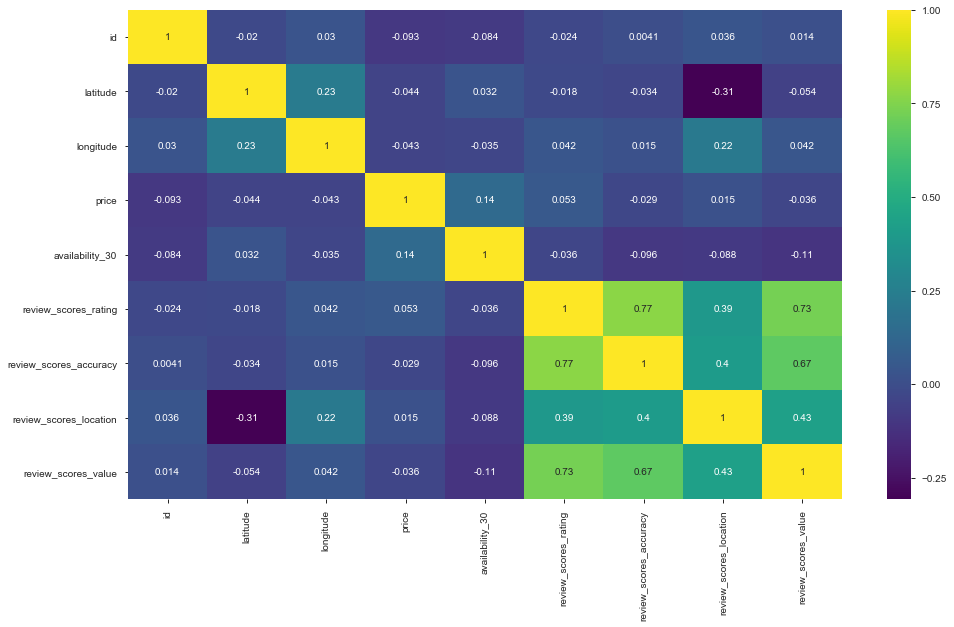

In [0]:
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(), annot=True, cmap='viridis')

In [0]:
!pip install cufflinks

    100% |████████████████████████████████| 81kB 1.9MB/s ta 0:00:01
  Stored in directory: /Users/nonoumasy/Library/Caches/pip/wheels/8d/5a/6f/c97d47dc901071611809eb61aaa477d50a60692dc764dca622
Successfully built cufflinks


In [0]:
import cufflinks as cf

@interact
def scatter_plot(x=list(df.select_dtypes('number').columns), 
                 y=list(df.select_dtypes('number').columns)[1:],
                 theme=list(cf.themes.THEMES.keys()), 
                 colorscale=list(cf.colors._scales_names.keys())):
    
    df.iplot(kind='scatter', x=x, y=y, mode='markers', 
             xTitle=x.title(), yTitle=y.title(), 
             text='title',
             title=f'{y.title()} vs {x.title()}',
            theme=theme, colorscale=colorscale)

TypeError: 'Series' object is not callable

# Neighborhoods - Let's get to know the area

In [0]:
@interact

def show_neighborhood(column='neighbourhood_cleansed', 
                            x=lis_neigh):
    return df.loc[df[column] == x]

interactive(children=(Text(value='neighbourhood_cleansed', description='column'), Dropdown(description='x', op…

In [0]:
n = widgets.Dropdown(options=df.neighbourhood_cleansed.unique())
n

Dropdown(options=('Belm', 'Santa Maria Maior', 'Areeiro', 'Estrela', 'Avenidas Novas', 'Misericrdia', 'So Vice…

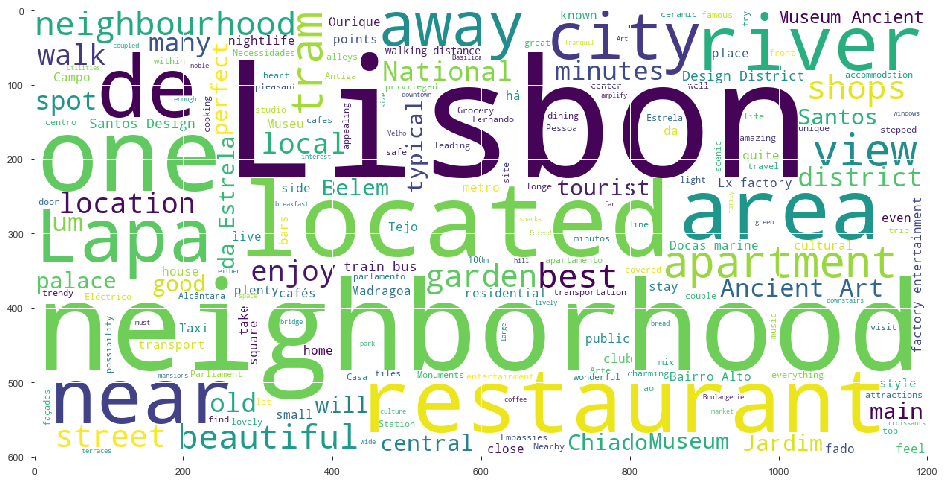

In [0]:
#Wordcloud of Neighborhoods

neighborhood_select = n.value

cat_words = df[df.neighbourhood_cleansed == neighborhood_select].neighborhood_overview.str.cat(sep=' ')

wc = WordCloud(width=1200, height=600, background_color='white', colormap='viridis').generate(cat_words)
plt.figure(figsize=(16,9))
plt.imshow(wc)
plt.show()

In [0]:
#Room type
df.groupby('room_type').id.count()

17713

In [76]:
#Number of Listings per neighborhood
listing_count

neighbourhood_cleansed
Carnide                     1
Beato                       1
Benfica                     1
Lumiar                      2
So Domingos de Benfica      2
Olivais                     4
Alcntara                    6
Ajuda                       7
Parque das Naes             7
Belm                        8
Campolide                   9
Areeiro                     9
Penha de Frana             10
Alvalade                   12
Campo de Ourique           13
Avenidas Novas             24
Estrela                    37
So Vicente                 53
Santo Antnio               69
Arroios                    75
Misericrdia               198
Santa Maria Maior         229
Name: id, dtype: int64

In [77]:
#Avg price by neighborhood
price_avg

neighbourhood_cleansed
Lumiar                     29.000000
Carnide                    30.000000
Ajuda                      48.428571
Beato                      55.000000
Olivais                    58.000000
Campolide                  58.888889
Penha de Frana             62.000000
Areeiro                    63.000000
So Domingos de Benfica     64.500000
Benfica                    65.000000
Avenidas Novas             65.625000
Belm                       67.250000
Alcntara                   75.000000
So Vicente                 75.433962
Campo de Ourique           77.076923
Santa Maria Maior          77.855895
Misericrdia                81.757576
Parque das Naes            83.000000
Arroios                    83.386667
Santo Antnio               87.391304
Alvalade                   88.583333
Estrela                   122.405405
Name: price, dtype: float64

In [78]:
#Avg Rating scores by neighborhood
rating_avg

neighbourhood_cleansed
Beato                     87.000000
Campolide                 88.142857
Areeiro                   89.142857
Benfica                   90.000000
Avenidas Novas            90.450000
Belm                      90.625000
Santo Antnio              91.544118
Penha de Frana            91.600000
Arroios                   91.819444
Ajuda                     92.000000
So Vicente                92.207547
Misericrdia               92.285714
Alvalade                  92.666667
Santa Maria Maior         92.762115
Alcntara                  93.000000
Estrela                   93.027778
Campo de Ourique          93.555556
So Domingos de Benfica    95.000000
Lumiar                    95.000000
Olivais                   95.750000
Parque das Naes           96.600000
Carnide                         NaN
Name: review_scores_rating, dtype: float64

In [0]:
#Avg Value scores by neighborhood
df.groupby('neighbourhood_cleansed').review_scores_value.mean().sort_values()

neighbourhood_cleansed
Beato                     9.044944
Carnide                   9.064516
Lumiar                    9.086207
Parque das Naes           9.086957
Avenidas Novas            9.097770
Marvila                   9.138462
Santo Antnio              9.150555
So Domingos de Benfica    9.169643
Arroios                   9.179659
Campo de Ourique          9.179811
Areeiro                   9.181818
Santa Maria Maior         9.200303
Estrela                   9.201726
Misericrdia               9.206884
Campolide                 9.231884
Belm                      9.232143
Alvalade                  9.237443
Penha de Frana            9.245968
So Vicente                9.274068
Ajuda                     9.298013
Olivais                   9.310811
Benfica                   9.339623
Alcntara                  9.361538
Santa Clara               9.416667
Name: review_scores_value, dtype: float64

In [0]:
#Number of Lisbon neighborhoods
df.neighbourhood_cleansed.nunique()

24

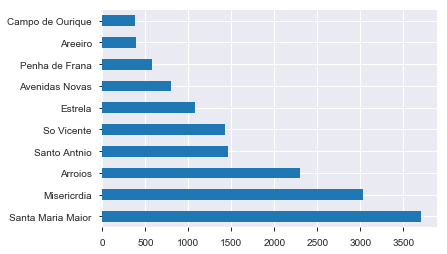

In [0]:
#Lisbon neighborhoods by listings count
df.neighbourhood_cleansed.value_counts()[:10].plot(kind='barh')

# Listings

In [0]:
df.groupby('neighbourhood_cleansed').availability_30.sum()

neighbourhood_cleansed
Ajuda                      1414
Alcntara                   2961
Alvalade                   2291
Areeiro                    3807
Arroios                   22720
Avenidas Novas             9060
Beato                       974
Belm                       3850
Benfica                     817
Campo de Ourique           3148
Campolide                  1703
Carnide                     374
Estrela                   10371
Lumiar                     1456
Marvila                     821
Misericrdia               27954
Olivais                    2006
Parque das Naes            4302
Penha de Frana             5721
Santa Clara                 216
Santa Maria Maior         32530
Santo Antnio              13207
So Domingos de Benfica     1690
So Vicente                12076
Name: availability_30, dtype: int64

In [0]:
#avg price by room type
df.groupby('room_type').price.mean()

room_type
Entire home/apt    105.180252
Private room        73.031722
Shared room         42.916268
Name: price, dtype: float64

In [0]:
#Least expensive rental price
df[df['price'] == 8.0].T

,9404
id,17260389
name,"Campo de Ourique, Lisboa"
summary,Possui um quarto que acomoda até 2 pessoas e ...
space,NaN
description,Possui um quarto que acomoda até 2 pessoas e ...
neighborhood_overview,NaN
notes,"Valores por quarto, para lugar todo consulte v..."
transit,NaN
neighbourhood_cleansed,Campo de Ourique
latitude,38.7179


In [0]:
#Interactive review score rating
@interact
def show_articles_more_than(column='review_scores_rating', x=(0,100)):
    return df.loc[df[column] > x]

In [0]:
@interact
def price_slider(column='price', x=(0,3500)):
    return df.loc[df[column] > x]

interactive(children=(Text(value='price', description='column'), IntSlider(value=1750, description='x', max=35…

In [0]:
df.groupby('neighbourhood_cleansed')['neighborhood_overview'].count()

neighbourhood_cleansed
Ajuda                       4
Alcntara                    4
Alvalade                    6
Areeiro                     5
Arroios                    48
Avenidas Novas             12
Beato                       1
Belm                        6
Benfica                     1
Campo de Ourique            7
Campolide                   3
Carnide                     0
Estrela                    24
Lumiar                      1
Misericrdia               128
Olivais                     2
Parque das Naes             2
Penha de Frana              7
Santa Maria Maior         145
Santo Antnio               40
So Domingos de Benfica      0
So Vicente                 32
Name: neighborhood_overview, dtype: int64

In [0]:
#Most expensive rental price
df[df['price'] == 3500]

,id,name,summary,space,description,neighborhood_overview,notes,transit,neighbourhood_cleansed,latitude,longitude,property_type,room_type,price,availability_30,review_scores_rating,review_scores_accuracy,review_scores_location,review_scores_value
1872,3067648,"CHAMPIONS LEAGUE FINAL, 5 MINUTES",Apartamento perfeito para quem vem assistir ao...,NaN,Apartamento perfeito para quem vem assistir ao...,NaN,NaN,NaN,Benfica,38.74701,-9.20582,Apartment,Entire home/apt,3500.0,0,NaN,NaN,NaN,NaN


In [0]:
df[(df['neighbourhood_cleansed'] == 'Santa Maria Maior') & (df['review_scores_rating'] == 100.0)].id.count()

320

In [0]:
df.head()

,id,name,summary,space,description,neighborhood_overview,notes,transit,neighbourhood_cleansed,latitude,...,room_type,square_feet,price,weekly_price,monthly_price,square_feet,availability_30,review_scores_rating,review_scores_location,comments
0,6499.0,Belém 1 Bedroom Historical Apartment,"This apartment is all about Location, next to ...",Fully furnished apartment (35m2). Small inside...,"This apartment is all about Location, next to ...","To get to the city center, tram 15 stops in f...",Late check in's (after 20H) have an extra char...,The apartment is on the same street as the #15...,Belm,38.69675,...,Entire home/apt,377.0,36.0,$209.00,$579.00,377.0,5.0,98.0,10.0,"Ola Bruno,\r\n\r\nTive um mes Fantástico em se..."
1,25659.0,"Sunny, Alfama Sleeps 3 - Coeur d'Alfama",Heart of Alfama! Center of Lisbon. Sunny Char...,Charming sunny apartment in the heart of Alfam...,Heart of Alfama! Center of Lisbon. Sunny Char...,Alfama is the oldest and most picturesque quar...,Check in after 3 PM although we try to accommo...,The apartment is very convenient to all kinds ...,Santa Maria Maior,38.71167,...,Entire home/apt,NaN,60.0,$350.00,NaN,NaN,5.0,96.0,10.0,Encontramos o apartamento de Bruno exatamente ...
2,28066.0,ear the birds,NaN,traditional farm house in a quiet place where ...,traditional farm house in a quiet place where ...,NaN,NaN,NaN,Aveiras de Cima,39.14654,...,Private room,NaN,53.0,NaN,NaN,NaN,30.0,NaN,NaN,Estivemos em Lisboa por aproximadamente 03 (tr...
3,29138.0,Room for rent in shared house,NaN,"05 minutes from city center by subway, 10 minu...","05 minutes from city center by subway, 10 minu...",NaN,NaN,NaN,Areeiro,38.73634,...,Private room,NaN,71.0,NaN,NaN,NaN,30.0,NaN,NaN,Superbe quartier très proche du tram et du tra...
4,29248.0,Apartamento Alfama com vista para o rio!,NaN,"Located in the city center, and great location...","Located in the city center, and great location...",NaN,NaN,NaN,Santa Maria Maior,38.71272,...,Entire home/apt,NaN,60.0,$299.00,$966.00,NaN,4.0,91.0,10.0,"Très bel appartement, bien situé et à proximit..."


In [0]:
# Function that returns number of words in a string
def count_words(string):
    # Split the string into words
    words = string.split()
    
    # Return the number of words
    return len(words)

# Create a new feature word_count
df['word_count'] = df['neighborhood_overview'].apply(count_words)

# Print the average word count of the talks
print(df['word_count'].sum())
print(df['word_count'].mean())

AttributeError: 'float' object has no attribute 'split'

In [0]:
from textblob import TextBlob

TextBlob(df.comments[1]).sentiment

Sentiment(polarity=0.0, subjectivity=0.0)

In [0]:
df.comments[1]

'Encontramos o apartamento de Bruno exatamente conforme a descrição e as fotos, além de muito bem limpo, cuidado com muito carinho e equipado com tudo o que é necessário e prático. Lençóis e toalhas disponíveis, travesseiros e uma cama extremamente confortável. A localização é incrível, segura e perfeita para visitar Lisboa. Todos os monumentos e locais históricos de Belém estão a alguns minutos da caminhada mais agradável da cidade, em meio a jardins, praças e restaurantes, e muitas opções de transportes para as outras zonas estão à porta do prédio. Numa estada mais extensa, como a nossa, é importante que o anfitrião esteja sempre ao alcance, e a atenção e a disponibilidade de Bruno realmente impressionam. Nenhuma de nossas comunicações e nenhum pequeno ajuste ou providência que foi necessária demorou mais do que alguns minutos. Uma de nossas melhores experiências no AirBnb.'

Text(0, 0.5, 'Neighborhood')

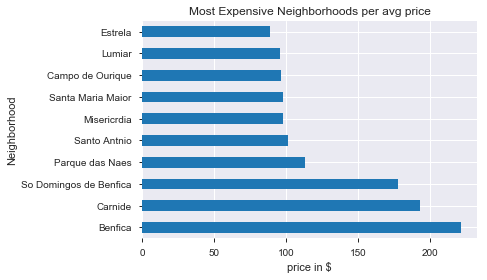

In [0]:
#Most Expensive Neighborhoods per avg price
df.groupby('neighbourhood_cleansed').price.mean().sort_values(ascending=False)[:10].plot(kind='barh')
plt.title('Most Expensive Neighborhoods per avg price')
plt.xlabel('price in $')
plt.ylabel('Neighborhood')

Text(0, 0.5, 'Neighborhood')

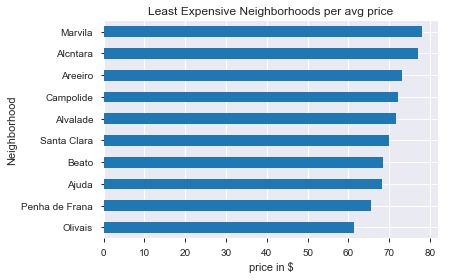

In [0]:
#Least Expensive Neighborhoods per avg price
df.groupby('neighbourhood_cleansed').price.mean().sort_values()[:10].plot(kind='barh')
plt.title('Least Expensive Neighborhoods per avg price')
plt.xlabel('price in $')
plt.ylabel('Neighborhood')

# NLP

In [0]:
#apply detect_lang to detect language or comment
reviews_df['lang'] = reviews_df.comments.apply(detect_langs)

#convert list to string
reviews_df['lang'] = [','.join(map(str, l)) for l in reviews_df['lang']]

#split
reviews_df['lang'] = reviews_df.lang.str.split(':', expand=True)[0]

#number of words in comment section
reviews_df['num_words'] = reviews_df.comments.apply(len)

#get sentiment of each comment
reviews_df['sentiment'] = reviews_df['comments'].apply(lambda x: TextBlob(x).sentiment)

#split tuple of polarity and subjectivity
reviews_df[['polarity', 'subjectivity']] = pd.DataFrame(reviews_df['sentiment'].tolist(), index=reviews_df.index)

#convert sentiment to 0(bad review) or 1(good review) in review column
reviews_df.loc[reviews_df.polarity < 0, 'review'] = 0    
reviews_df.loc[reviews_df.polarity > 0, 'review'] = 1    



,listing_id,id,reviewer_id,reviewer_name,comments,lang
date,,,,,,
2010-07-24,29915,68476,161179,Tina,This was really great for our stay in Lisbon. ...,[en:0.9999967605307145]
2010-09-05,29915,90628,198217,Ralf,"Sara's apartment i very spacious, clean and co...",[en:0.9999964261467764]
2010-09-15,29915,97766,187957,Wiktor,"The apartment was very nice, well equipped and...",[en:0.9999950299023841]
2010-12-06,29915,149289,249928,Steven,Sara made everything easy. She was quick to re...,[en:0.9999963155145735]
2011-01-01,29248,161788,290662,Seth,Very nice little place in the heart of the his...,[en:0.9999939028822221]


In [0]:
#number of (1)good and (0)bad reviews
reviews_df.review.value_counts()

1.0    765
0.0     34
Name: review, dtype: int64

In [0]:
#number of different language reviews
reviews_df.lang.value_counts()[:10]

en    696
fr    155
es     45
de     39
pt     26
it     22
ko      3
sv      3
nl      3
ru      2
Name: lang, dtype: int64

# Map

In [0]:
#variables
listing_count = df.groupby('neighbourhood_cleansed').id.count().sort_values()
price_avg = df.groupby('neighbourhood_cleansed').price.mean().sort_values()
rating_avg = df.groupby('neighbourhood_cleansed').review_scores_rating.mean().sort_values()

#load geojson file
gdf = gpd.read_file('/content/drive/My Drive/Colab Notebooks/airbnb_lisbon/map.geojson')
gdf.drop('neighbourhood_group', axis=1, inplace=True)
gdf.columns = ['neighbourhood_cleansed', 'geometry']
gdf.set_index('neighbourhood_cleansed', inplace=True)
gdf.sort_index(inplace=True)

#series to dataframe
df2 = listing_count.to_frame()
df3 = price_avg.to_frame()
df4 = rating_avg.to_frame()

#merge dataframes
dfs = [gdf, df2, df3, df4]
new_gdf = gdf.merge(df2,on='neighbourhood_cleansed').merge(df3,on='neighbourhood_cleansed').merge(df4,on='neighbourhood_cleansed')
# new_gdf.drop(['id_x', 'id_y'], axis=1, inplace=True)


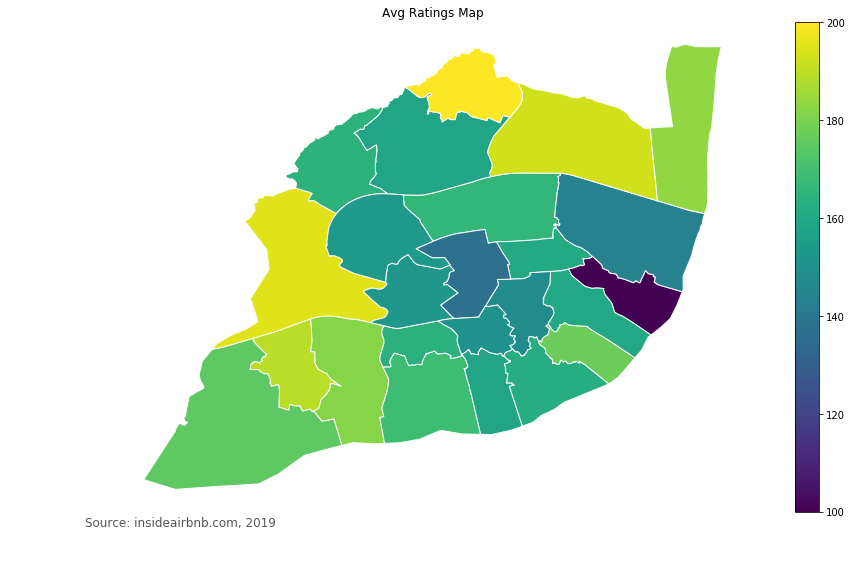

In [181]:
# Avg Ratings Map
new_gdf.plot('review_scores_rating', figsize=(16,9), edgecolor='w')
plt.title('Avg Ratings Map')
plt.axis('off')
plt.annotate('Source: insideairbnb.com, 2019',
             xy=(0.1, .08),  
             xycoords='figure fraction', 
             horizontalalignment='left', 
             verticalalignment='top', 
             fontsize=12, 
             color='#555555')

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = plt.colorbar(sm)

plt.show()
             

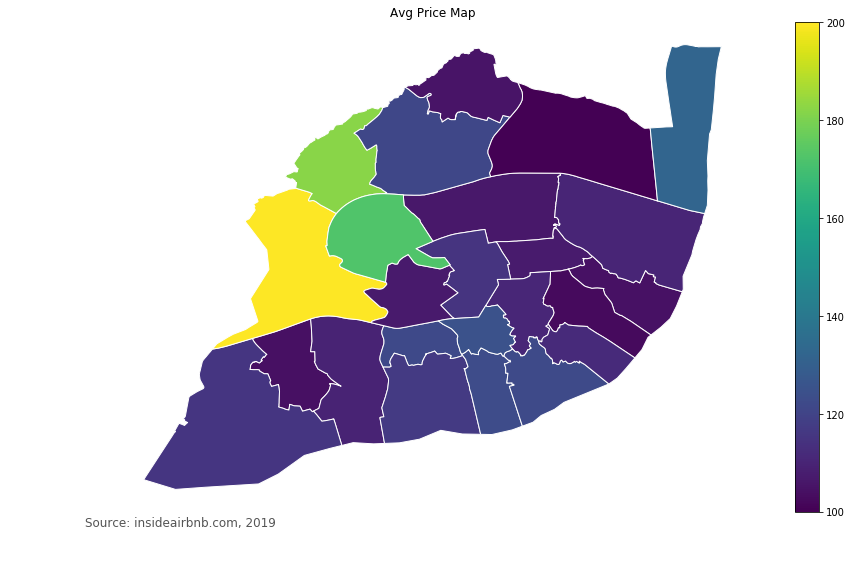

In [182]:
# Avg Price Map
new_gdf.plot('price', figsize=(16,9), edgecolor='w')
plt.title('Avg Price Map')
plt.axis('off')
plt.annotate('Source: insideairbnb.com, 2019',
             xy=(0.1, .08),  
             xycoords='figure fraction', 
             horizontalalignment='left', 
             verticalalignment='top', 
             fontsize=12, 
             color='#555555')
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = plt.colorbar(sm)
plt.show()
             

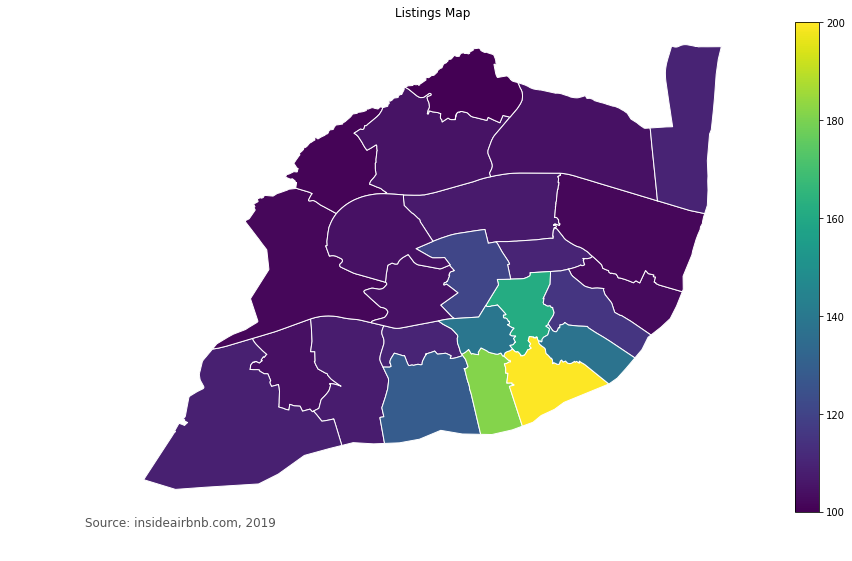

In [183]:
# Listings Map
new_gdf.plot('id', figsize=(16,9), edgecolor='w')
plt.title('Listings Map')
plt.axis('off')
plt.annotate('Source: insideairbnb.com, 2019',
             xy=(0.1, .08),  
             xycoords='figure fraction', 
             horizontalalignment='left', 
             verticalalignment='top', 
             fontsize=12, 
             color='#555555')
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = plt.colorbar(sm)

plt.show()
             
             

In [192]:
geolocator = Nominatim(user_agent="airbnb_lisbon")
loc = geolocator.geocode('Alfama')
lis_loc = (loc.latitude, loc.longitude)

m = folium.Map(lis_loc, zoom_start=12, tiles='cartodbpositron')
folium.plugins.Fullscreen(position='bottomright').add_to(m)



geo = '/content/drive/My Drive/Colab Notebooks/airbnb_lisbon/map.geojson'
folium.GeoJson(geo,
               name="Lisbon Rental prices by neighborhood").add_to(m)

folium.Choropleth(
    geo_data=geo,
    name='choropleth',
    data=choro_df,
    columns=['neighbourhood_cleansed', 'price'],
    key_on='properties.neighbourhood',
    fill_color='Blues',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Rental Prices(USD)'
).add_to(m)

m


In [193]:
geolocator = Nominatim(user_agent="airbnb_lisbon")
loc = geolocator.geocode('Lisbon')
lis_loc = (loc.latitude, loc.longitude)

loc_list = df[['latitude', 'longitude']].values.tolist()
m = folium.Map(lis_loc, zoom_start=12, tiles='StamenWatercolor')
folium.plugins.Fullscreen(position='bottomright').add_to(m)

FastMarkerCluster(loc_list).add_to(m)
HeatMap(loc_list, min_opacity=0.3).add_to(m)

m



# Time-Series

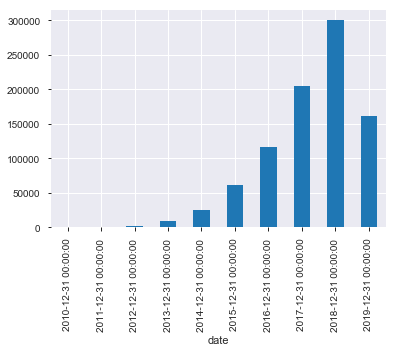

In [0]:
reviews_df.resample('A').id.count().plot(kind='bar')


# Key Findings(Insights)

* Most Expensive Neighborhood: Benfica
* Least Expensive Neighbordhood: Olvais
* Current Availability: 59%
* Highest rating per neighborhood: Santa Clara
* Lowest rating per neighborhood: Beato
* Highest Location rating per neighborhood: Santa Maria Maior
* Santa Maria Maior has 320 listings with a perfec 100% rating score
* Most expensive rental price is 3500 USD and is located in the Benfica neighborhood
* Average Reviews Rating Score is: 92%
* Least Expensive Listing is a private room at 8 USD located in Campo de Ourique.
* Santa Maria Maior neighborhood has the most listings with 3708
* Santa Clara has the least listings with 20
* The touristy area tends to have most listings. This makes sense.
* However the most expensive listings tends to be not in the main touristy areas, Benfica, Carnide, Santo Domingo Benfica, Parque de Nacoes.
* 
